In [1]:
import numpy as np
from scipy.special import logsumexp
import seaborn as sns
import pandas as pd
import os
import matplotlib.pyplot as plt
from equilibrator_api import ComponentContribution, Q_, Reaction
import requests
import xmltodict
import pint
import cvxpy as cp
import itertools
import copy
from convex_kinetics_new import ConvexKineticsNew

sns.set(style='darkgrid', palette='viridis', context='talk')

os.chdir(os.path.expanduser('~/vivarium-ecoli'))

A + B -E1> C -E2> D

B -E3> F

A -E4> G

# Testing eQuilibrator

In [2]:
cc = ComponentContribution()

# optional: changing the aqueous environment parameters
cc.p_h = Q_(7.4)
cc.p_mg = Q_(3.0)
cc.ionic_strength = Q_("0.25M")
cc.temperature = Q_("298.15K")



In [3]:
from equilibrator_api import Reaction
compound_ids = ["WATER", "ADP", "ATP", "Pi"]
compound_dict = {cid : cc.get_compound(f"metacyc.compound:{cid}") for cid in compound_ids}
atpase_reaction = Reaction({
    compound_dict["ATP"]: -1,
    compound_dict["WATER"]: -1,
    compound_dict["ADP"]: 1,
    compound_dict["Pi"]: 1,
})

In [4]:
standard_dg_prime = cc.standard_dg_prime(atpase_reaction)
standard_dg_prime

<Measurement(-29.144472212600157, 0.30427785535776736, kilojoule / mole)>

In [5]:
cytoplasmic_p_h = Q_(7.5)
cytoplasmic_ionic_strength = Q_("250 mM")
periplasmic_p_h = Q_(7.0)
periplasmic_ionic_strength = Q_("200 mM")
e_potential_difference = Q_("0.15 V")
cytoplasmic_reaction = "bigg.metabolite:pep = bigg.metabolite:g6p + bigg.metabolite:pyr"
periplasmic_reaction = "bigg.metabolite:glc__D = "

cc = ComponentContribution()
cc.p_h = cytoplasmic_p_h
cc.ionic_strength = cytoplasmic_ionic_strength
standard_dg_prime = cc.multicompartmental_standard_dg_prime(
    cc.parse_reaction_formula(cytoplasmic_reaction),
    cc.parse_reaction_formula(periplasmic_reaction),
    e_potential_difference=e_potential_difference,
    p_h_outer=periplasmic_p_h,
    ionic_strength_outer=periplasmic_ionic_strength,
)

print(standard_dg_prime)


(-44.8 +/- 0.6) kilojoule / mole


In [6]:
cc.get_compound_by_inchi("WQZGKKKJIJFFOK-GASJEMHNSA-N")

# Using eQuilibrator to generate equilibrium constants

In [7]:
s = requests.Session() # create session
# Post login credentials to session:
s.post('https://websvc.biocyc.org/credentials/login/', data={'email':'cellulararchitect@protonmail.com', 'password':'#'})
# Issue web service request:
r = s.get('https://websvc.biocyc.org/getxml?id=ECOLI:6PFRUCTPHOS-RXN&detail=low&fmt=json')

In [8]:
name = 'F16ALDOLASE-RXN'

r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
o = xmltodict.parse(r.content)['ptools-xml']
o['Reaction']['enzymatic-reaction']['Enzymatic-Reaction'][0]['@frameid']

'F16ALDOLASE-ENZRXN-CLASSI'

In [9]:

rxns_names = ['6PFRUCTPHOS-RXN', 'F16ALDOLASE-RXN', '2TRANSKETO-RXN', 'TRIOSEPISOMERIZATION-RXN']

rxns_dict = {}
stoich_dict = {}
regulation_dict = {}

for name in rxns_names:
    r = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{name}&detail=low&fmt=json')
    rxn = xmltodict.parse(r.content)['ptools-xml']

    rxn_dict = {}
    stoich_loop_dict = {}
    regulation_loop_dict = {}
    left = rxn['Reaction']['left']
    right = rxn['Reaction']['right'] 
    
    # i will know exact complex in model (connected to rxn), but for now will pick random
    enz_rxn = rxn['Reaction']['enzymatic-reaction']['Enzymatic-Reaction']
    
    if type(left) is dict:
        left = [left]
    
    if type(right) is dict:
        right = [right]
        
    if type(enz_rxn) is dict:
        enz_rxn = [enz_rxn]
    
    enz_rxn_id =  enz_rxn[0]['@frameid']
    re = s.get(f'https://websvc.biocyc.org/getxml?id=ECOLI:{enz_rxn_id}&detail=high&fmt=json')
    oe = xmltodict.parse(re.content)['ptools-xml']['Enzymatic-Reaction']['regulated-by']['Regulation']
    
    if type(oe) is dict:
        oe = [oe]
        
    # add regulators, target regulator directly with id to get info like irreversible, etc
    for regulator in oe:
        reg_name = regulator['regulator']['Compound']['@frameid']
        reg_type = regulator['mode']['#text']
        reg_type = 1 if reg_type == '+' else -1
        regulation_loop_dict[reg_name] = reg_type
    
    for mol in left:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] = -1
            stoich_loop_dict[cid] = -1

    for mol in right:
        if type(mol) is dict:
            cid = mol['Compound']['@frameid']
            mol_cc = cc.get_compound(f"metacyc.compound:{cid}")
            rxn_dict[mol_cc] =  1
            stoich_loop_dict[cid] = 1
    
    rxns_dict[name] = Reaction(rxn_dict)
    stoich_dict[name] = stoich_loop_dict
    regulation_dict[name] = regulation_loop_dict
    
rxns_dict

{'6PFRUCTPHOS-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x1569be440>,
 'F16ALDOLASE-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x1074de6e0>,
 '2TRANSKETO-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x1074ddab0>,
 'TRIOSEPISOMERIZATION-RXN': <equilibrator_api.phased_reaction.PhasedReaction at 0x1074f6980>}

In [10]:
(standard_dg_prime, dg_uncertainty) = cc.standard_dg_prime_multi(list(rxns_dict.values()), uncertainty_representation="cov")

In [11]:
standard_dg_prime

Magnitude,[-21.05010908198642 22.047924530096907 -5.946115510564027 -5.617742386692498]
Units,kilojoule/mole


In [12]:
dg_uncertainty

Magnitude,[[1.5398212990074907 -2.216747118056975 0.6541085596545124 -0.004664260811859866] [-2.216747118056975 5.286946034707539 -2.4322877177623585 -0.12911827360174233] [0.6541085596545124 -2.4322877177623585 5.547270812427002 -0.08893998540651439] [-0.004664260811859866 -0.12911827360174233 -0.08893998540651439 0.3010346102557633]]
Units,kilojoule2/mole2


In [13]:
R = 0.008314 # kJ/mol*K
T = 298.15 # K

In [14]:
dG = standard_dg_prime._magnitude

keq = np.exp(-dG/(R*T))
keq

K_eq = np.log(keq)

# Calculating set of kinetic parameters with given equilibrium constants and arbitrary fluxes

In [15]:
Sd = pd.DataFrame(stoich_dict).fillna(0).astype(np.int8)
# Sd = Sd.iloc[0:7, 0:2]

n_rxn = Sd.shape[1]
n_met = Sd.shape[0]

Sd

Sd["6PFRUCTPHOS-RXN"] = Sd["6PFRUCTPHOS-RXN"] # * 2
Sd

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,-1,0,1,0
ATP,-1,0,0,0
PROTON,1,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,1,-1,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,1,0,1
GAP,0,1,1,-1
ERYTHROSE-4P,0,0,-1,0
XYLULOSE-5-PHOSPHATE,0,0,-1,0


In [16]:
Sr_min = pd.DataFrame(regulation_dict).fillna(0).astype(np.int8)

Sr = Sd.copy()
Sr.loc[:,:] = 0
Sr.loc[Sd.index.intersection(Sr_min.index), :] = Sr_min.loc[Sd.index.intersection(Sr_min.index), :]
Sr

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
FRUCTOSE-6P,1,0,0,0
ATP,0,0,0,0
PROTON,0,0,0,0
ADP,1,0,0,0
FRUCTOSE-16-DIPHOSPHATE,0,0,0,0
DIHYDROXY-ACETONE-PHOSPHATE,0,0,0,0
GAP,0,0,0,0
ERYTHROSE-4P,0,0,0,0
XYLULOSE-5-PHOSPHATE,0,0,0,0


In [17]:
K_eq = np.log(keq)
K_eq_mod = K_eq[:, np.newaxis].T
vE = np.array([[90, 70, -30, 50], [100, 100, 30, 50], [110, 60, 75, 50]])
# vE[:, 0] = vE[:, 0] / 2

n_flux_set = vE.shape[0]

# K_eq[vE < 0] = 1/K_eq[vE < 0]

lvE = np.log(np.abs(vE))
pd.DataFrame(np.concatenate([K_eq_mod, vE, np.sign(vE, dtype=np.int8)]), columns=Sd.columns,
             index=["$K_{eq}$", "$v_1$", "$v_2$", "$v_3$", "sign 1", "sign 2", "sign 3"])

,6PFRUCTPHOS-RXN,F16ALDOLASE-RXN,2TRANSKETO-RXN,TRIOSEPISOMERIZATION-RXN
$K_{eq}$,8.491991,-8.894527,2.398769,2.266298
$v_1$,90.000000,70.000000,-30.000000,50.000000
$v_2$,100.000000,100.000000,30.000000,50.000000
$v_3$,110.000000,60.000000,75.000000,50.000000
sign 1,1.000000,1.000000,-1.000000,1.000000
sign 2,1.000000,1.000000,1.000000,1.000000
sign 3,1.000000,1.000000,1.000000,1.000000


In [18]:
# set up variables

S_mol = np.array(Sd)
S = np.sign(S_mol) #
S_s = -np.copy(S) # reverse neg sign
S_p = np.copy(S)
S_s[S > 0] = 0 # zeros products
S_p[S < 0] = 0 # zeros substrates
S_i = np.copy(np.array(Sr) == -1) # reaction direction does not matter
S_a = np.copy(np.array(Sr) == 1)


S_s_nz = np.array(S_s.nonzero())
S_p_nz = np.array(S_p.nonzero())
S_i_nz = np.array(S_i.nonzero())
S_a_nz = np.array(S_a.nonzero())
S_s_mol = np.abs(S_mol)[S_s.nonzero()]
S_p_mol = np.abs(S_mol)[S_p.nonzero()]

# TODO Refactor all the below lines as one liners
# first coordinate, e.g. metabolites w nonzero substrate/product coeff across all reactions. also works as substrate indices.
met_s_nz = S_s_nz[0, :]
met_p_nz = S_p_nz[0, :]
met_i_nz = S_i_nz[0, :]
met_a_nz = S_a_nz[0, :]

# second coordinate, e.g. reactions indices for those concentrations. works to index substrates as well.
rxn_s_nz = S_s_nz[1, :]
rxn_p_nz = S_p_nz[1, :]
rxn_i_nz = S_i_nz[1, :]
rxn_a_nz = S_a_nz[1, :]

# one dim is always 2
n_Km_s = np.max(met_s_nz.shape)
n_Km_p = np.max(met_p_nz.shape)
n_Km_i = np.max(met_i_nz.shape)
n_Km_a = np.max(met_a_nz.shape)

c = cp.Variable([n_met, n_flux_set])
Km_s = cp.Variable(n_Km_s)
Km_p = cp.Variable(n_Km_p)
Km_i = cp.Variable(n_Km_i) if n_Km_i else None
Km_a = cp.Variable(n_Km_a) if n_Km_a else None

cfwd = cp.Variable(n_rxn)
crev = cp.Variable(n_rxn)

# define y vecs
y_s_t = []
y_p_t = []
y_i_t = []
y_a_t = []

# define Km positions by nonzero S matrix concentrations. Activation is reverse val of inhibition.
# TODO Add molecularity here.
for i in range(n_flux_set):
    y_s_t.append(cp.multiply(S_s_mol, c[met_s_nz, i] - Km_s))
    y_p_t.append(cp.multiply(S_p_mol, c[met_p_nz, i] - Km_p))
    y_i_t.append(c[met_i_nz, i] - Km_i if n_Km_i else None)
    y_a_t.append(-(c[met_a_nz, i] - Km_a) if n_Km_a else None)

y_s = cp.vstack(y_s_t)
y_p = cp.vstack(y_p_t)
y_i = cp.vstack(y_i_t)
y_a = cp.vstack(y_a_t)

# saturation stacks
y_f_vec = [y_s]
y_r_vec = [y_p]
if n_Km_i:
    y_f_vec.append(y_i)
    y_r_vec.append(y_i)
if n_Km_a:
    y_f_vec.append(y_a)
    y_r_vec.append(y_a)

y_f = cp.hstack(y_f_vec)
y_r = cp.hstack(y_r_vec)

In [19]:
# number of saturation terms for sub, prod
S_s_comb = np.concatenate((S_s, S_i, S_a), axis=0)
S_p_comb = np.concatenate((S_p, S_i, S_a), axis=0)
n_alpha = np.sum(np.power(2, np.sign(S_s_comb).sum(axis=0)) - 1)
n_beta = np.sum(np.power(2, np.sign(S_p_comb).sum(axis=0)) - 1)

# saturation matrix setup, first sub, then inhib, then act.
C_alpha = np.zeros([n_alpha, len(met_s_nz) + len(met_i_nz) + len(met_a_nz)])
C_beta = np.zeros([n_beta, len(met_p_nz) + len(met_i_nz) + len(met_a_nz)])

# to separate different reactions saturation terms to their individual reaction equations.
d_alpha = np.zeros(n_alpha, dtype=np.int8)
d_beta = np.zeros(n_beta, dtype=np.int8)


idx = 0

for i in range(n_rxn):

    # pick one reaction at a time (get substrate indicies)
    #idx_cur_rxn = rxn_s_nz == i
    # TODO This does not properly multiply by molecularity. Alternatively, generate C_alpha and
    # TODO beta without molecularity (first ==1) and then multiply by molecularity in the end.
    idx_cur_rxn = np.concatenate((rxn_s_nz == i, rxn_i_nz == i, rxn_a_nz == i))

    # generates all binary permutations minus the first one since that would result in -1
    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    # replace zeros with saturation matrix
    C_alpha[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_alpha[idx:(idx+r)] = i

    idx += r # add row #

idx = 0

for i in range(n_rxn):
    idx_cur_rxn = np.concatenate((rxn_p_nz == i, rxn_i_nz == i, rxn_a_nz == i))

    sat_perm = np.array(list(itertools.product([0, 1], repeat=sum(idx_cur_rxn))))
    sat_perm = sat_perm[1:, :]

    r, _ = sat_perm.shape

    C_beta[idx:(idx+r), idx_cur_rxn] = sat_perm
    d_beta[idx:(idx+r)] = i

    idx += r # add row #

In [20]:
C_alpha

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [21]:
n_lse_terms = np.max(np.power(2, S_s.sum(axis=0)) +  np.power(2, S_p.sum(axis=0)) - 2)
LSE_expr = []
denom_expr = []

sign = np.sign(vE)
lvE = np.log(sign * vE)

for j in range(n_flux_set):
    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)

        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p

        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            LSE_expr.append(cp.hstack( [
                                         lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],
                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) - cfwd[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                         cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  + crev[i]
                                            - cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  - cfwd[i],

                                       ]
                                     )
                           )  # remove +1 here, could also have cfwd outside objec.

            denom_expr.append(cp.multiply(np.ones(1), -S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx])) + cfwd[i],)


        # keep saturation term the same, switch around fwd and rev terms. flip all signs with S matrix since it's signed.
        if sign[j, i] == -1:
            LSE_expr.append(cp.hstack( [ lvE[j, i] + (C_alpha @ cp.vec(y_f[j, :]))[d_alpha == i]
                                            - cp.multiply(np.ones(n_term_s), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + (C_beta @ cp.vec(y_r[j, :]))[d_beta == i]
                                            - cp.multiply(np.ones(n_term_p), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         lvE[j, i] + 0 - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                         cp.multiply(np.ones(1), - S.T[i, S_s_idx] @ cp.vec(y_s[j, Km_s_idx]))  + cfwd[i]
                                            - cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) - crev[i],

                                       ]
                                     )
                           )

            denom_expr.append(cp.multiply(np.ones(1), S.T[i, S_p_idx] @ cp.vec(y_p[j, Km_p_idx])) + crev[i])


#LSE_expr = cp.vstack(LSE_expr)
LSE_expr

[Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,)),
 Expression(AFFINE, UNKNOWN, (48,)),
 Expression(AFFINE, UNKNOWN, (6,)),
 Expression(AFFINE, UNKNOWN, (8,)),
 Expression(AFFINE, UNKNOWN, (4,))]

In [22]:
l = 0.001
e = 0.001
f = 0.000001
reg =  cp.sum(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.sum(cp.hstack([-Km_s, -Km_p])) # regularization
reg2 = cp.norm1(cp.hstack([cfwd, crev, cp.vec(c)])) + cp.norm1(cp.hstack([-Km_s, -Km_p])) # regularization
reg3 = cp.sum(cp.huber(cp.hstack([y_s, y_p]), 1)) # issue with matrix

if n_Km_i:
    reg += cp.sum(cp.hstack([-Km_i]))
if n_Km_a:
    reg += cp.sum(cp.hstack([-Km_a]))
#reg3 = cp.norm1(cp.hstack([y_s, y_p])) # take a look at this

loss = 0
for i in range(len(LSE_expr)):
    loss += cp.norm1(cp.pos(cp.log_sum_exp(LSE_expr[i])))
for i in range(len(denom_expr)):
    loss += 0.01 * denom_expr[i]
loss += l * reg
loss += e * reg2
# loss += f * reg3
#

In [23]:
constr = [cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) >= -12,
          cp.hstack([cfwd, crev, cp.vec(c), Km_s, Km_p]) <= 12,
          ]

if n_Km_i:
    constr.extend([Km_i >= -12, Km_i <= 12])
if n_Km_a:
    constr.extend([Km_a >= -12, Km_a <= 12])



In [24]:
haldane = []
fwd_flux = []

for i, r in enumerate(S.T):
    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

    haldane.append(K_eq[i] == cfwd[i] - crev[i] + r[S_p_idx] @ Km_p[Km_p_idx] - (-r[S_s_idx]) @ Km_s[Km_s_idx])

for j in range(n_flux_set):
    for i, r in enumerate(S.T):
        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        if sign[j, i] == 1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  >= 0)  # add minus since s matrix has minus

        if sign[j, i] == -1:
            fwd_flux.append(cfwd[i] + (-r[S_s_idx]) @ cp.vec(y_s[j, Km_s_idx]) - (crev[i] + r[S_p_idx] @ cp.vec(y_p[j, Km_p_idx]))  <= 0)  # add minus since s matrix has minus

    constr.extend([cp.multiply(S.T @ cp.vec(c[:, j]), sign[j, :])  <= cp.multiply(K_eq, sign[j, :])])

constr.extend(haldane)
constr.extend(fwd_flux)

In [25]:
p = cp.Problem(cp.Minimize(loss), constr)
p.solve(verbose=True, solver=cp.ECOS)

                                     CVXPY                                     
                                     v1.4.3                                    
(CVXPY) May 04 11:33:07 AM: Your problem has 51 variables, 23 constraints, and 0 parameters.
(CVXPY) May 04 11:33:07 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 04 11:33:07 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 04 11:33:07 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 04 11:33:07 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 04 11:33:07 AM: Compiling problem (target solver=ECOS).
(CV

0.6527584055951398

In [26]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])

concs = np.exp(c.value).T
for row in concs:
    print('Concentration:', [f'{val:.4f}' for val in row])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['23.895', '10.336', '11.495', '1.058', '1.792', '1.792']
Product Km: ['31.112', '1.000', '1.463', '20.747', '0.193', '0.999', '1.000', '1.000']
Fwd kcat: ['39678.055', '1329.487', '5070.525', '850.010']
Rev kcat: ['1.000', '162732.740', '4459.575', '83.212']
Concentration: ['3.7831', '0.1928', '0.0000', '0.0542', '0.6843', '0.0000', '0.0662', '0.0000', '0.0000']
Concentration: ['0.8177', '1.0000', '0.0000', '0.0535', '1.0000', '0.0000', '0.0662', '0.1719', '0.1719']
Concentration: ['0.8840', '1.0000', '0.0000', '0.0538', '0.5823', '0.0000', '0.0662', '0.2698', '0.2698']
Activation Km: ['0.020', '0.001']


In [27]:
for v in LSE_expr:
    #print(v.value)
    print(logsumexp(v.value))

-1.2318651482767784e-06
-1.7974280498711526e-07
-1.3402933257689043e-07
-1.8793507894354633e-07
-1.0730781659362698e-06
-1.5509815351477663e-07
-2.3356250705708348e-07
-1.0040161903257516e-07
-1.1511761434657153e-06
-1.8146268292162926e-07
-2.22083093026626e-07
-1.0881231516518541e-07


Perfect? Wow.

# Check flux reconstruction with inhibition/activation

In [28]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)
        n_term_s = np.sum(d_alpha == i)
        n_term_p = np.sum(d_beta == i)
        n_term = n_term_s + n_term_p


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        #S_s_idx = S_s_nz[0, S_s_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) # + cfwd.value[i]
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten())) # + cfwd.value[i]



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[ 90.00011087  70.00001264 -30.00000402  50.0000094 ]
[100.00010731 100.00001556  30.00000841  50.00000502]
[110.00012663  60.00001094  75.00001797  50.00000544]


In [29]:
df_vE = pd.DataFrame(vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2", "Flux set 3"]).melt(ignore_index=False).reset_index(drop=False)
df_vE["kind"] = "Actual flux"
df_recon = pd.DataFrame(reconstructed_vE, columns=Sd.columns, index=["Flux set 1", "Flux set 2", "Flux set 3"]).melt(ignore_index=False).reset_index(drop=False)
df_recon["kind"] = "Reconstructed flux"

df_reconstr_comp = pd.concat([df_vE, df_recon]).reset_index(drop=True)
df_reconstr_comp

,index,variable,value,kind
0,Flux set 1,6PFRUCTPHOS-RXN,90.000000,Actual flux
1,Flux set 2,6PFRUCTPHOS-RXN,100.000000,Actual flux
2,Flux set 3,6PFRUCTPHOS-RXN,110.000000,Actual flux
3,Flux set 1,F16ALDOLASE-RXN,70.000000,Actual flux
4,Flux set 2,F16ALDOLASE-RXN,100.000000,Actual flux
5,Flux set 3,F16ALDOLASE-RXN,60.000000,Actual flux
6,Flux set 1,2TRANSKETO-RXN,-30.000000,Actual flux
7,Flux set 2,2TRANSKETO-RXN,30.000000,Actual flux
8,Flux set 3,2TRANSKETO-RXN,75.000000,Actual flux
9,Flux set 1,TRIOSEPISOMERIZATION-RXN,50.000000,Actual flux


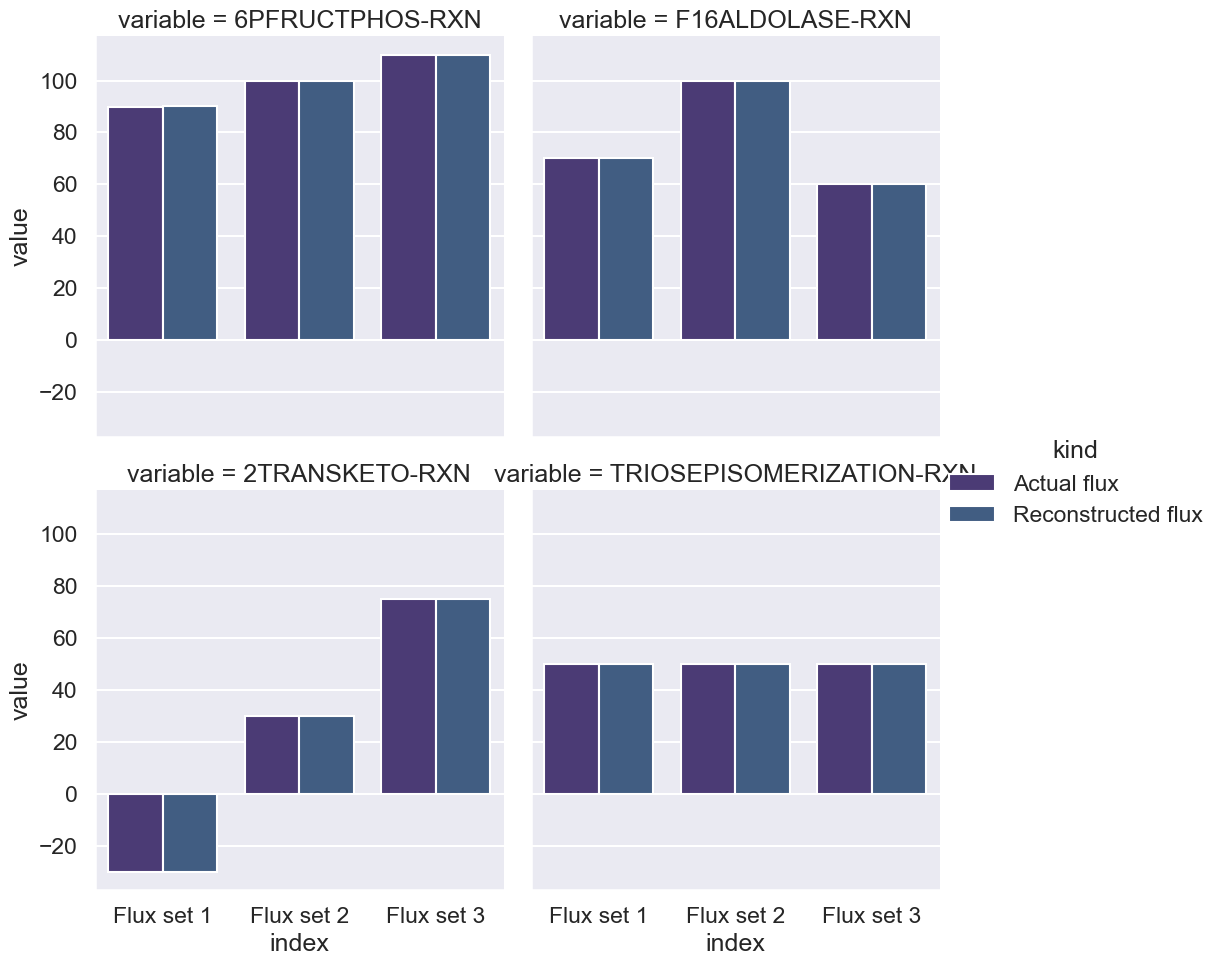

In [30]:
sns.catplot(x="index", y="value", hue="kind", col="variable", kind="bar", data=df_reconstr_comp, height=5, aspect=1, col_wrap=2)
plt.savefig("flux_set_comparison.svg")

# Stupid class based method

In [31]:
%load_ext autoreload
%autoreload 2

In [32]:
from convex_kinetics_new import ConvexKineticsNew

In [33]:
E = ConvexKineticsNew()
y_f, y_r, y_s, y_p, y_i, y_a, cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, S_s, S_p, S_i, S_a, \
            met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz, \
            n_rxn, n_met, n_flux_set, S_s_nz, S_p_nz, S = E.set_up_variables(S_matrix=Sd, R_matrix=Sr, flow_data=vE)

Number of metabolites: 9, number of reactions: 4, number of flux sets: 3
Number of Km_s: 6, number of Km_p: 8, number of Km_i: 0, number of Km_a: 2
Number of concentrations: (9, 3), number of y_f: (3, 8), number of y_r: (3, 10)


In [34]:
C_alpha, C_beta, d_alpha, d_beta = E.construct_binding_matrix(n_rxn, S_s, S_p, S_i, S_a, Sr, met_s_nz, met_p_nz, met_i_nz, met_a_nz, rxn_s_nz, rxn_p_nz, rxn_i_nz, rxn_a_nz)

Shape of C_alpha: (20, 8), shape of C_beta: (38, 10)
Shape of d_alpha: (20,), shape of d_beta: (38,)


In [35]:
LSE_expr, denom_expr = E.construct_kinetic_objective(vE, n_flux_set, n_rxn, C_alpha, C_beta, d_alpha, d_beta, S_s_nz, S_p_nz, S, y_f, y_r, y_s, y_p, cfwd, crev)

In [36]:
loss = E.create_objective_function(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a, y_s, y_p, LSE_expr, denom_expr)

In [37]:
constr = E.set_parameter_bounds(cfwd, crev, c, Km_s, Km_p, Km_i, Km_a)

In [38]:
constr = E.add_mechanistic_constraints(constr, vE, K_eq, S, S_s_nz, S_p_nz, cfwd, crev, Km_s, Km_p, n_flux_set, y_s, y_p, c)

In [39]:
problem = E.set_up_problem(loss, constr)

In [40]:
solution = E.solve(problem)

In [41]:
solution.value

0.6527584158591424

In [42]:
p.value

0.6527584055951398

In [43]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])

concs = np.exp(c.value).T
for row in concs:
    print('Concentration:', [f'{val:.4f}' for val in row])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['23.809', '10.336', '11.495', '1.058', '1.789', '1.789']
Product Km: ['31.001', '1.000', '1.458', '20.747', '0.193', '0.999', '1.000', '1.000']
Fwd kcat: ['39678.086', '1329.487', '5070.524', '850.010']
Rev kcat: ['1.000', '162729.221', '4459.573', '83.202']
Concentration: ['3.7696', '0.1928', '0.0000', '0.0540', '0.6843', '0.0000', '0.0662', '0.0000', '0.0000']
Concentration: ['0.8148', '1.0000', '0.0000', '0.0533', '1.0000', '0.0000', '0.0662', '0.1715', '0.1715']
Concentration: ['0.8809', '1.0000', '0.0000', '0.0536', '0.5823', '0.0000', '0.0662', '0.2693', '0.2693']
Activation Km: ['0.019', '0.001']


In [44]:
print('Substrate Km:', [f'{val:.3f}' for val in np.exp(Km_s.value)])
print('Product Km:', [f'{val:.3f}' for val in np.exp(Km_p.value)])
print('Fwd kcat:', [f'{val:.3f}' for val in np.exp(cfwd.value)])
print('Rev kcat:', [f'{val:.3f}' for val in np.exp(crev.value)])

concs = np.exp(c.value).T
for row in concs:
    print('Concentration:', [f'{val:.4f}' for val in row])

if n_Km_i:
    print('Inhibition Km:', [f'{val:.3f}' for val in np.exp(Km_i.value)])
if n_Km_a:
    print('Activation Km:', [f'{val:.3f}' for val in np.exp(Km_a.value)])

Substrate Km: ['23.809', '10.336', '11.495', '1.058', '1.789', '1.789']
Product Km: ['31.001', '1.000', '1.458', '20.747', '0.193', '0.999', '1.000', '1.000']
Fwd kcat: ['39678.086', '1329.487', '5070.524', '850.010']
Rev kcat: ['1.000', '162729.221', '4459.573', '83.202']
Concentration: ['3.7696', '0.1928', '0.0000', '0.0540', '0.6843', '0.0000', '0.0662', '0.0000', '0.0000']
Concentration: ['0.8148', '1.0000', '0.0000', '0.0533', '1.0000', '0.0000', '0.0662', '0.1715', '0.1715']
Concentration: ['0.8809', '1.0000', '0.0000', '0.0536', '0.5823', '0.0000', '0.0662', '0.2693', '0.2693']
Activation Km: ['0.019', '0.001']


In [59]:
reconstructed_vE = np.zeros(vE.shape)

for j in range(n_flux_set):
    sat_expr = []
    fwd_sat = np.zeros(n_rxn)
    back_sat = np.zeros(n_rxn)
    sat = np.zeros(n_rxn)

    for i in range(n_rxn):
        # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)


        Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
        S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

        Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
        S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

        sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                     (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                     0,
                                     #-1*np.ones(n_lse_terms - n_term + 1)
                                   ]
                       )
        fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) 
        back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten()))



    for i, rxn in enumerate(sat_expr):
        s = 0

        for term in rxn:
            s += np.sum(np.exp(term))

        sat[i] = (s)

    reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
    print(reconstr)
    reconstructed_vE[j, :] = reconstr

[ 90.0001306   70.00001497 -30.00000441  50.00001114]
[100.00012651 100.00001843  30.00000995  50.00000594]
[110.00014927  60.00001297  75.00002126  50.00000644]


In [65]:
C_alpha

array([[0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 1., 1.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 1., 1.],
       [1., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0., 1.],
       [1., 1., 0., 0., 0., 0., 1., 0.],
       [1., 1., 0., 0., 0., 0., 1., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.]])

In [58]:
dmdt_ext = S @ reconstructed_vE.T
dmdt_ext

array([[-1.20000135e+02, -7.00001166e+01, -3.50001280e+01],
       [-9.00001306e+01, -1.00000127e+02, -1.10000149e+02],
       [ 9.00001306e+01,  1.00000127e+02,  1.10000149e+02],
       [ 9.00001306e+01,  1.00000127e+02,  1.10000149e+02],
       [ 2.00001156e+01,  1.08082576e-04,  5.00001363e+01],
       [ 1.20000026e+02,  1.50000024e+02,  1.10000019e+02],
       [-1.00000006e+01,  8.00000224e+01,  8.50000278e+01],
       [ 3.00000044e+01, -3.00000099e+01, -7.50000213e+01],
       [ 3.00000044e+01, -3.00000099e+01, -7.50000213e+01]])

# Function that calculates fluxes from concentrations and basic parameters

In [ ]:
# let's just first testing predicting one dmdt 
v = np.zeros(n_rxn)



In [67]:
reconstructed_vE = np.zeros(vE.shape)

j = 0

sat_expr = []
fwd_sat = np.zeros(n_rxn)
back_sat = np.zeros(n_rxn)
sat = np.zeros(n_rxn)

for i in range(n_rxn):
    # sum terms are separate in logsumexp. one per saturation term (row in C_alpha, C_beta)


    Km_s_idx = np.nonzero(S_s_nz[1, :] == i)
    S_s_idx = S_s_nz[0, S_s_nz[1, :] == i] # negate -1 entries

    Km_p_idx = np.nonzero(S_p_nz[1, :] == i)
    S_p_idx = S_p_nz[0, S_p_nz[1, :] == i]

    sat_expr.append(           [ (C_alpha @ y_f.value[j, :].flatten())[d_alpha == i] ,
                                 (C_beta @ y_r.value[j, :].flatten())[d_beta == i],
                                 0,
                                 #-1*np.ones(n_lse_terms - n_term + 1)
                               ]
                   )
    fwd_sat[i] = (np.exp(-S.T[i, S_s_idx] @ y_s.value[j, Km_s_idx].flatten())) 
    back_sat[i] = (np.exp(S.T[i, S_p_idx] @ y_p.value[j, Km_p_idx].flatten()))



for i, rxn in enumerate(sat_expr):
    s = 0

    for term in rxn:
        s += np.sum(np.exp(term))

    sat[i] = (s)

reconstr = np.exp(cfwd.value) * fwd_sat/sat - np.exp(crev.value) * back_sat/sat
print(reconstr)
reconstructed_vE[j, :] = reconstr

[ 90.0001306   70.00001497 -30.00000441  50.00001114]


# Try forward simulation

In [47]:
# each of the four compounds has a concentration and a sum of fluxes as derivative 
def dmdt(c, t):
    
    

array([1.29114374, 1.11685118, 1.42017316, 1.0625064 ])